## Two Vector Choice Optimization 

Problem we consider is 
$$ max_{0 \leq z \leq 1}  z v^T \theta + (1-z) w^T \theta = \max(v^T \theta, w^T\theta $$

We only have access to $X_i \sim \mathcal N(\theta_i, 1/\tau_i)$ for $i = 1, 2$.  


**Naive Boundary**: $$(v-w)^T X > 0$$


__Bayesian Solution under Normal priors__: 
$$ \sum_{i=1}^n \alpha_i (v_i-w_i) X_i > 0 $$
where $\alpha_i = \frac{\tau_i}{\tau_0 + \tau_i}$


This has an intuitive form:  Downweight components that are known to be noisy.  Amount of downweighting depends on $\tau_0$.

- In limit $\tau_0 = 0$, we retrieve naive decision boundary.
- As $\tau_0 \rightarrow \infty$, differences between precision matter less.



In [1]:
using Distributions, PyPlot

/Users/vishalgupta/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


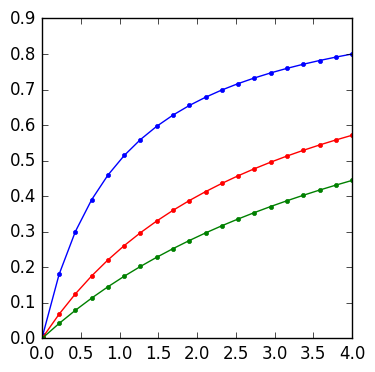

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d2879d0>

In [21]:
figure(figsize=(4, 4))
taus_grid = linspace(.01, 4, 20)
plot(taus_grid, taus_grid ./ (1 + taus_grid), ".-b")
plot(taus_grid, taus_grid ./ (3 + taus_grid), ".-r")
plot(taus_grid, taus_grid ./ (5 + taus_grid), ".-g")

In [2]:
cumnorm(x) = cdf(Normal(), x)
alpha(tau0, taus)  = taus ./ (tau0 + taus)
function BLoss(thetas, v, w, tau0, taus)
    diff = dot(v-w, thetas)
    alphas = alpha(tau0, taus)
    num = sum(alphas .* (w-v) .* thetas)
    den = sqrt(sum(alphas.^2 .* (w-v).^2 ./ taus))
    out = diff * cumnorm(num / den)
    if diff <= 0
        out -= diff
    end
    out
end

FLoss(thetas, v, w, taus) = BLoss(thetas, v, w, 0, taus)

FLoss (generic function with 1 method)

## Specific Example

In [3]:
v = [1; 0.]
w = [0; 1]
M = 5
thetas = [0.; 1.]
##Particular to our example
taus(M) = [1; 1/M^2]

taus (generic function with 1 method)

In [ ]:
###Example 2
v = [1; 1]
w = [0; 0]
ts = [2; .5]
thetas = [1; 2]

Consider Fixing $\tau_0 = 1$.  Would like to understand for what values of $\theta$ do we do better by shrinking?

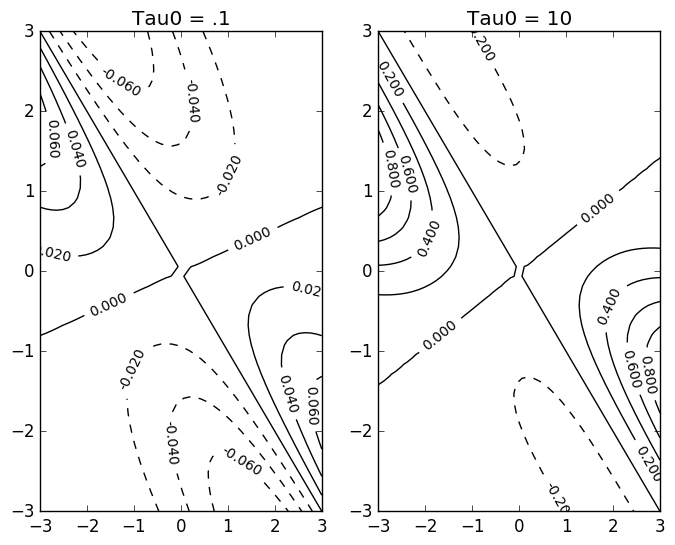

PyObject <matplotlib.text.Text object at 0x3213499d0>

In [70]:
function surf_plot(theta_grid, tau0, ts = taus(M))
    n = length(theta_grid)
    z = zeros(Float64, n, n)
    for i = 1:n
        for j = 1:n
            thetas = [theta_grid[i]; theta_grid[j]]
            z[i, j] = BLoss(thetas, v, w, tau0, ts) - BLoss(thetas, v, w, 0, ts)
        end
    end
    z
end

n = 50
theta_grid = linspace(-3., 3., n)
z1 = surf_plot(theta_grid, .1, ts)
z3 = surf_plot(theta_grid, 10, ts)

#fig = figure("pyplot_surfaceplot",figsize=(5,5))
subplot(1, 2, 1)
CS = contour(theta_grid, theta_grid, z1, colors="black", linewidth=2.0)
clabel(CS, inline=1, fontsize=10)
title("Tau0 = .1")

subplot(1, 2, 2)
CS = contour(theta_grid, theta_grid, z3, colors="black", linewidth=2.0)
clabel(CS, inline=1, fontsize=10)
title("Tau0 = 10")

In regions where we improve, optimal value seems to be $\tau_0 \rightarrow \infty$.  

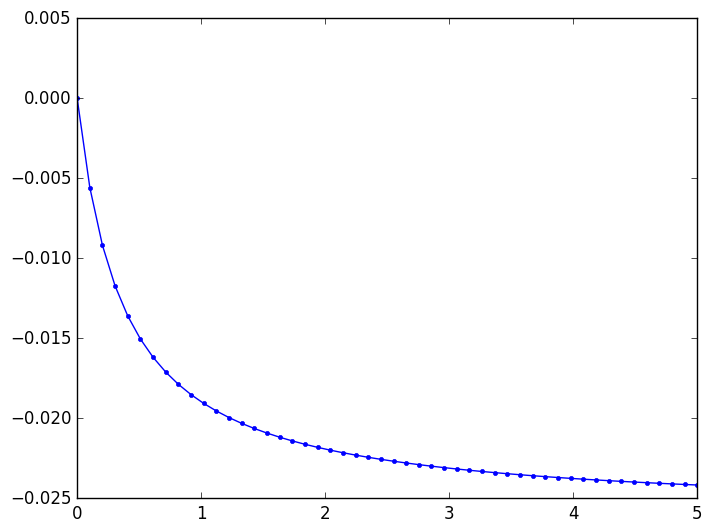

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x321dcd850>

In [74]:
v = [1; 1]
w = [0; 0]
ts = [.4; .5]
thetas = [1; 2]
tau0_grid = linspace(0, 5, 50)
outs = map(tau0 -> BLoss(thetas, v, w, tau0, ts) - BLoss(thetas, v, w, 0, ts), tau0_grid)
plot(tau0_grid, outs, ".-b")

**How do we define the regions?**

It seems the regions are independent of $\tau_0$, which is weird.  The line is defined by the solution to the linear equation (in $\theta$)

$$\frac{\sum_i \alpha_i (w_i - v_i)\theta_i}{\| A (w-v) \|_\tau }  = \frac{\sum_i (w_i - v_i)\theta_i}{\| w-v \|_\tau}$$
Only terms that depend on $\tau_0$ are $A$.

In [37]:
function coeffs(taus, tau0, v, w)
    alphas =  taus ./ (tau0 + taus)
    denom = sqrt(sum(alphas.^2 .* (w-v).^2 ./ taus))
    out = alphas / denom
    
    denom2 = sqrt(sum((w-v).^2 ./ taus))
    out -= (w-v) / denom2
    out[2]/out[1]
end

[coeffs(taus(M), 1e-3, v, w)  coeffs(taus(M), 1e5, v, w)]


1x2 Array{Float64,2}:
 -0.00046065  -0.133333

In [39]:
D(tau0, M) = sqrt(1/(tau0+1)^2 + M^2 / (tau0 * M^2 + 1)^2 )

D (generic function with 2 methods)

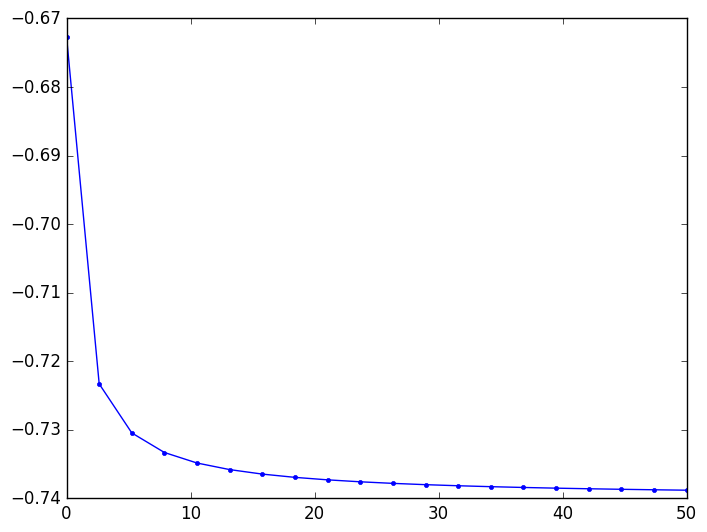

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31dc52ed0>

In [43]:
thetas = [1; 0]
@assert thetas[1] > thetas[2] "Improper Thetas"

M = 1.1

f(tau0) = -thetas[1] / (tau0 + 1) / D(tau0, M) + thetas[2]/(tau0*M^2 +1) / D(tau0, M)

t_grid = linspace(0, 50, 20)
plot(t_grid, map(f, t_grid), ".-b")




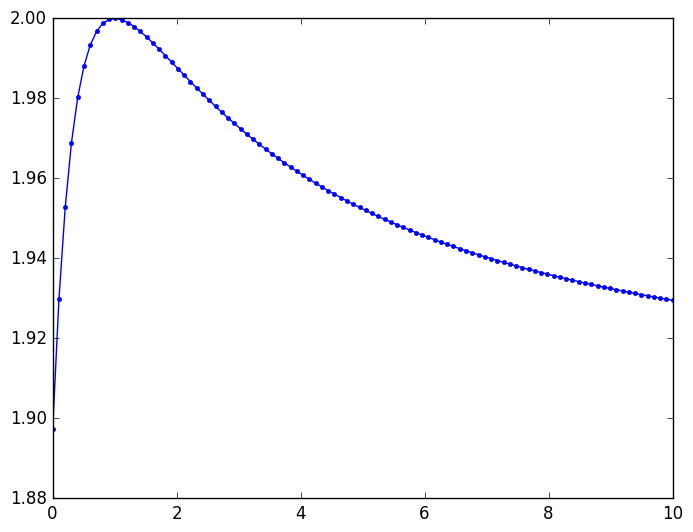

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x320aff2d0>

In [67]:
ts = [2; .5]
thetas = [1; 2]
function f(tau0)
    alphas = ts ./ (tau0 + ts)
    denom = sqrt(sum( alphas.^2 ./ ts ))
    dot(alphas, thetas)/denom
end

t_grid = linspace(0, 10, 100)
plot(t_grid, map(f, t_grid), ".-b")


## Counter Example to Asymptotic SURE

We can then attempt to estimate the reward via the usual expansion:
$$ \sum_i Y_i \mathbb I( \alpha^T X  > 0 )$$

We claim that this expansion may be inconsistent.  

Counterexample

$$ \mathbf w = \mathbf 0$$
$$ \mathbf v = \mathbf e$$

$\theta_i = 1/5$ if $i$ is odd, and $-1/9$ otherwise.  

$\tau_i = 1$ if $i$ is odd, and $9$ otherwise.  $\tau_0 = 1$.  

In [89]:
n = 100000
thetas = 1/5 * ones(n)
thetas[2:2:n] = -1/9
ts = ones(n)
ts[2:2:n] = 9
tau0 = 1
vs = ones(n)
ws = zeros(n)


alphas = ts ./ (ts + tau0)
norm_alphas = sqrt(sum(ts./ (ts + tau0).^2))

130.38404810405297

In [95]:
outs = zeros(100)
for iSim = 1:100
    Xs = [sqrt(1/ts[i]) * randn() + thetas[i] for i = 1:n]
    Ys = [sqrt(1/ts[i]) * randn() + thetas[i] for i = 1:n]

    function f(Xs, Ys)
        out = 0
        if dot(alphas, Xs) > 0
            out = mean(Ys)
        end
        out - mean(thetas) * cumnorm( dot(alphas, thetas)/norm_alphas)
    end
    outs[iSim] = f(Xs, Ys)
end    

outs

100-element Array{Float64,1}:
 -0.0222222
  0.0210987
  0.0232433
 -0.0222222
  0.0237028
  0.0217858
  0.0206801
 -0.0222222
  0.0243962
 -0.0222222
  0.022898 
  0.0219985
  0.0196015
  ⋮        
  0.0217888
  0.0236016
  0.0235933
 -0.0222222
  0.0258462
  0.0197907
  0.0222222
 -0.0222222
 -0.0222222
  0.0204668
 -0.0222222
  0.0208959